In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11104686485340238076
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3150367948
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4578382067391761611
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import ResNetModel

Using TensorFlow backend.


In [3]:
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [4]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('./data/resnet50_cifar10.csv')

batch_size = 32
nb_classes = 10
nb_epoch = 100
data_augmentation = True

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

model = ResNetModel.ResnetBuilder.build_resnet_50((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model = multi_gpu_model(model, gpus=G)
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train[:37500], Y_train[:37500],
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_train[37500:], Y_train[37500:]),
              shuffle=True,
              callbacks=[lr_reducer, early_stopper, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(X_train[:37500], Y_train[:37500], batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_train[37500:], Y_train[37500:]),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        callbacks=[lr_reducer, early_stopper, csv_logger])


Instructions for updating:
Colocations handled automatically by placer.
Using real-time data augmentation.


C:\ProgramData\Anaconda2\envs\stats\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1562, validation_data=(array([[[..., epochs=100, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1562/1562 [==============================] - 278s 178ms/step - loss: 3.9205 - acc: 0.4395 - val_loss: 2.3031 - val_acc: 0.5490
Epoch 2/100
1562/1562 [==============================] - 251s 161ms/step - loss: 2.1162 - acc: 0.5330 - val_loss: 2.0569 - val_acc: 0.5241
Epoch 3/100
1562/1562 [==============================] - 250s 160ms/step - loss: 1.9095 - acc: 0.5463 - val_loss: 1.7875 - val_acc: 0.5505
Epoch 4/100
1562/1562 [==============================] - 251s 161ms/step - loss: 1.6830 - acc: 0.5922 - val_loss: 1.8678 - val_acc: 0.5701
Epoch 5/100
1562/1562 [==============================] - 252s 161ms/step - loss: 1.5647 - acc: 0.6195 - val_loss: 1.4280 - val_acc: 0.6487
Epoch 6/100
1562/1562 [==============================] - 254s 163ms/step - loss: 1.4010 - acc: 0.6505 - val_loss: 1.4016 - val_acc: 0.6536
Epoch 7/100
1562/1562 [==============================] - 251s 160ms/step - loss: 1.3193 - acc: 0.6695 - val_loss: 1.20

1562/1562 [==============================] - 249s 159ms/step - loss: 0.4229 - acc: 0.9237 - val_loss: 0.6702 - val_acc: 0.8557
Epoch 58/100
1562/1562 [==============================] - 249s 159ms/step - loss: 0.4103 - acc: 0.9265 - val_loss: 0.6777 - val_acc: 0.8516
Epoch 59/100
1562/1562 [==============================] - 249s 159ms/step - loss: 0.4077 - acc: 0.9270 - val_loss: 0.6811 - val_acc: 0.8527
Epoch 60/100
1562/1562 [==============================] - 249s 159ms/step - loss: 0.4053 - acc: 0.9271 - val_loss: 0.6721 - val_acc: 0.8527
Epoch 61/100
1562/1562 [==============================] - 251s 161ms/step - loss: 0.3920 - acc: 0.9309 - val_loss: 0.6894 - val_acc: 0.8462
Epoch 62/100
1562/1562 [==============================] - 250s 160ms/step - loss: 0.3871 - acc: 0.9327 - val_loss: 0.6839 - val_acc: 0.8496
Epoch 63/100
1562/1562 [==============================] - 250s 160ms/step - loss: 0.3744 - acc: 0.9373 - val_loss: 0.6688 - val_acc: 0.8551
Epoch 64/100
1562/1562 [=========

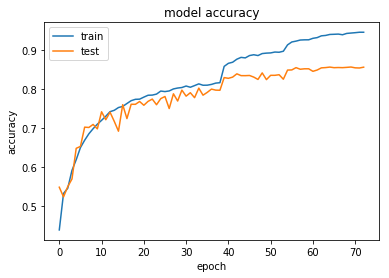

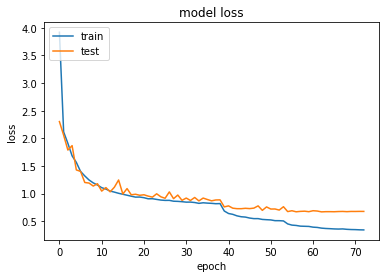

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./data/figs/resnet50_accuracy.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./data/figs/resnet50_loss.jpg')
plt.show()


In [25]:
print(Y_test)
print(y_pred)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0.

In [16]:
test_datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images

validation_gen = test_datagen.flow(X_test, Y_test, batch_size=1)
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_gen, 
                                 10000)
y_pred = np.argmax(Y_pred, axis=1)

Confusion Matrix


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [24]:
y_pred = np_utils.to_categorical(y_pred, nb_classes)

#print('Confusion Matrix')
#print(confusion_matrix(Y_test, y_pred))
print('Classification Report')
target_names = ["airplane ","automobile" ,"bird" ,"cat" ,
                    "deer" ,"dog" ,"frog" ,"horse","ship","truck"]
print(classification_report(Y_test, y_pred, target_names=target_names))

Classification Report


ValueError: Classification metrics can't handle a mix of multilabel-indicator and unknown targets

#### Save model for deployment

In [ ]:
model.save('./models/keras-resnet50_25eps.pkl')